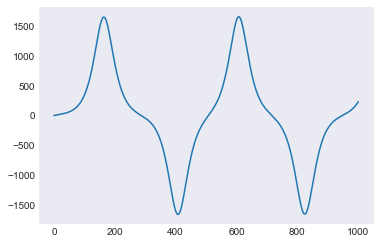

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn-dark")
import sys
sys.path.append('..')

from DA_PoC.filters.ETKF import ETKF
from DA_PoC.dynamicalsystems.anharmonic_oscillator import NonLinearOscillatorModel
%matplotlib inline

Among the common imports, we import the EnKF class, that we wish to apply to the NonLinearOscillatorModel.
We define the linear observation operator 
$$H = [1, 0] \in \mathbb{R}^{1\times 2}$$
which will be applied to a column vector $\mathbb{R}^{p \times 1}$ with $p=2$ representing the state.

We have then $\mathcal{Y}\subseteq \mathbb{R}$ the physical space (or observation space), and as such, the covariance matrix of the observation errors $R$ is a scalar

In [2]:
H = np.atleast_2d([0, 1])
R = np.atleast_2d([49])
state_dimension = 2
period_assim = 25
Nensemble = 64
Nsteps=200
inflation_factor = 1.10
initial_state = np.array([0, 1])



We are first going to define the observations (ie the truth), here in a twin experiment setup.
We define a function which generates the observations directly from the truth model (but can be modified since its argument is the index of the assimilation step)

In [3]:
# Reference model
# NonLinearOscillatorModel.xi = [0] # No model error
truth = NonLinearOscillatorModel()

truth.set_initial_state(0, initial_state)
def generate_observations(i):
    truth.forward(period_assim)
    y = truth.state_vector[:, -1] + np.random.randn(1) * np.sqrt(float(R))
    return truth.t[-1], y


In [4]:
etkf = ETKF(state_dimension, Nensemble, R)
etkf.set_forwardmodel(lambda x: NonLinearOscillatorModel.integrate(0, x, period_assim,)[1][:, -1])
etkf.H = H
etkf.R = R


In [5]:
siginit = 1
covariance = siginit * np.eye(2)
etkf.generate_ensemble(mean=initial_state, cov=covariance)


In [6]:
truth.set_initial_state(0, initial_state, force_reset=True)
dETKF = etkf.run(Nsteps, get_obs=generate_observations)

In [7]:
t = np.asarray(dETKF['time'])
xf = np.asarray(dETKF['ensemble_f'])
xfbar = xf.mean(2)
xa = np.asarray(dETKF['ensemble_a'])
xabar= xa.mean(2)
obs = np.asarray(dETKF['observations'])
print("Sanity check for the dimensions of")
print(f"{t.shape=}\n{xf.shape=}\n{xa.shape=}\n{obs.shape=}")

Sanity check for the dimensions of
t.shape=(200,)
xf.shape=(200, 2, 64)
xa.shape=(200, 2, 64)
obs.shape=(200, 2)


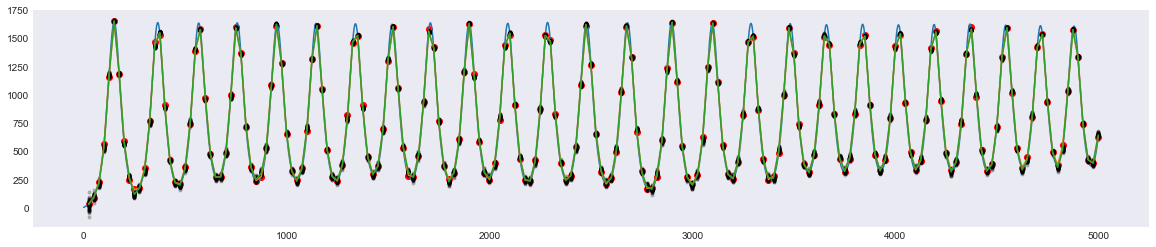

In [8]:
plt.figure(figsize=(20, 4))
plt.plot(t, obs[:, 0], 'or')
plt.plot(truth.t, truth.state_vector[0, :])
plt.plot(t, xf[:, 0, :], '.', color='black', alpha=0.2)
plt.plot(t, xabar[:, 0])
plt.plot(t, xfbar[:, 0])

     Analysis error:   32.002117040190385
  Observation error:    54.69329846363778


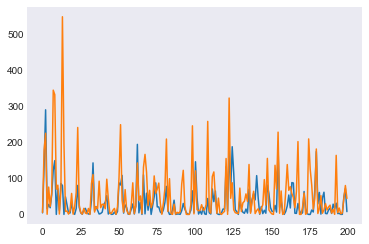

In [9]:
analysis_error = xabar[:, 0] - truth.state_vector[0, period_assim::period_assim]
observation_error = obs[:, 0] - truth.state_vector[0, period_assim::period_assim]
ea = (analysis_error**2).mean()
eo = (observation_error**2).mean()

plt.plot(analysis_error**2)
plt.plot(observation_error**2)
print(f"{'Analysis error:': >20} {ea:>20}")
print(f"{'Observation error:': >20} {eo:>20}")

10938.659692727557


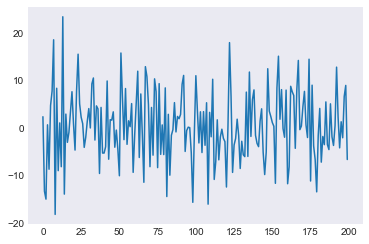

In [10]:
plt.plot(observation_error)
print((observation_error**2).sum())